# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе найдём месторождения, для каждого определяем значения признаков;
- Построим модель и оценим объём запасов;
- Выберем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Цели и задачи проекта

**Цели:**

Провести исследование с целью построения модели машинного обучения, которая поможет определить регион, где добыча нефти принесёт наибольшую прибыль.

Результаты исследования позволят увеличить прибыль добывающей компании «ГлавРосГосНефть».

**Задачи:**

1. Загрузим и подготовим данные. Поясним порядок действий.


2. Обучим и проверим модель для каждого региона:

   2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.
   
   2.2. Обучим модель и сделаем предсказания на валидационной выборке.
   
   2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
   
   2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
   
   2.5. Проанализируем результаты.


3. Подготовимся к расчёту прибыли:

   3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.
   
   3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.
   
   3.3. Напишем выводы по этапу подготовки расчёта прибыли.
   
   
4. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

   4.1. Выберем скважины с максимальными значениями предсказаний.
   
   4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
   
   4.3. Рассчитаем прибыль для полученного объёма сырья.
   
   
5. Посчитаем риски и прибыль для каждого региона:

   5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
   
   5.2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
   
   5.3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.


В ходе проведения исследования нам необходимо проверить гипотезу:

- Гипотеза: среди трёх регионов есть те, в которых вероятность убытков меньше 2.5%

# Описание данных

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.

Данные геологоразведки трёх регионов находятся в файлах:
- `/datasets/geo_data_0.csv`
- `/datasets/geo_data_1.csv`
- `/datasets/geo_data_2.csv`

**Признаки:**
- *id* — уникальный идентификатор скважины
- *f0*, *f1*, *f2* — три признака точек (неважно, что они означают, но сами признаки значимы)

**Целевой признак:**
- *product* — объём запасов в скважине (тыс. баррелей)

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# План работы

1. Загрузка и подготовка данных
2. Обучение и проверка модели
3. Подготовка к расчёту прибыли
4. Расчёт прибыли и рисков 
5. Общий вывод

## Загрузка и подготовка данных

**Задача 1. Загрузим и подготовим данные. Поясним порядок действий.**

In [1]:
import pandas as pd # для загрузки данных и преобразования списков в объекты Series
import numpy as np # для создания объекта RandomState() из модуля numpy.random при применении техники Bootstrap
import matplotlib.pyplot as plt # для построения распределений переменных
SAMPLE_SIZE = 500 # количество скважин, которое исследуют при разведке региона
COUNT = 200 # количество лучших скважин, которые нужно выбрать для разработки в каждом регионе с помощью машинного обучения
COST = 10_000_000 # бюджет (расходы) на разработку скважин в регионе (тыс. рублей), заложенный на 200 скважин
REVENUE_PER_UNIT_PRODUCT = 450 # доход с каждой единицы продукта (тыс. рублей на 1 тыс. баррелей)
from sklearn.model_selection import train_test_split # для разбиения данных на обучающую и валидационную выборки
from sklearn.linear_model import LinearRegression # для создания модели линейной регрессии
from sklearn.metrics import mean_squared_error # для расчета RMSE модели

1. Исследуем данные региона geo_data_0.

In [2]:
# Выведем размеры и первые 10 строк данных geo_data_0:
data_0 = pd.read_csv(r'C:/Users/lorad/OneDrive/Documents/Моя папка/Data Science/Мои проекты/GitHubRepositories/'
                 'YandexPracticum/06_project_work_ML_in_business_choosing_a_location_for_a_well/geo_data_0.csv')
data_0.shape

(100000, 5)

In [3]:
data_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [4]:
# Проверим явные дубликаты в датасете data_0:
data_0.duplicated().sum()

0

In [5]:
# Выведем общую информацию о датасете data_0:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


2. Исследуем данные региона geo_data_1.

In [6]:
# Выведем размеры и первые 10 строк датасета data_1:
data_1 = pd.read_csv(r'C:/Users/lorad/OneDrive/Documents/Моя папка/Data Science/Мои проекты/GitHubRepositories/'
                 'YandexPracticum/06_project_work_ML_in_business_choosing_a_location_for_a_well/geo_data_1.csv')
data_1.shape

(100000, 5)

In [7]:
data_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [8]:
# Проверим явные дубликаты в датасете data_1:
data_1.duplicated().sum()

0

In [9]:
# Выведем общую информацию о датасете data_1:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


3. Исследуем данные региона geo_data_2.

In [10]:
# Выведем размеры и первые 10 строк датасета data_2:
data_2 = pd.read_csv(r'C:/Users/lorad/OneDrive/Documents/Моя папка/Data Science/Мои проекты/GitHubRepositories/'
                 'YandexPracticum/06_project_work_ML_in_business_choosing_a_location_for_a_well/geo_data_2.csv')
data_2.shape

(100000, 5)

In [11]:
data_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


In [12]:
# Проверим явные дубликаты в датасете data_2:
data_2.duplicated().sum()

0

In [13]:
# Выведем общую информацию о датасете data_2:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Общий вывод по всем трём датасетам: 
- в каждом регионе - по 100000 скважин;
- явных дубликатов и пропусков нет;
- кодирование категориальных признаков не нужно, т.к. все признаки в датасетах - численные;
- масштабирование численных признаков не нужно, т.к. для обучения моделей будет применяться линейная регрессия.

4. Удалим из датасетов столбцы *'id'*, т.к. их данные не влияют на целевой признак *'product'* - объём запасов в скважине (тыс. баррелей).

In [14]:
# Сначала введём новую переменную data_all и сохраним в ней в виде списка данные по всем трём регионам.
# Удалим из датасетов столбцы 'id', 
# т.к. их данные не влияют на целевой признак 'product' - объём запасов в скважине (тыс. баррелей):
data_all = [
    data_0.drop('id', axis=1),
    data_1.drop('id', axis=1),
    data_2.drop('id', axis=1),
]
display(data_all)

[             f0        f1        f2     product
 0      0.705745 -0.497823  1.221170  105.280062
 1      1.334711 -0.340164  4.365080   73.037750
 2      1.022732  0.151990  1.419926   85.265647
 3     -0.032172  0.139033  2.978566  168.620776
 4      1.988431  0.155413  4.751769  154.036647
 ...         ...       ...       ...         ...
 99995  0.971957  0.370953  6.075346  110.744026
 99996  1.392429 -0.382606  1.273912  122.346843
 99997  1.029585  0.018787 -1.348308   64.375443
 99998  0.998163 -0.528582  1.583869   74.040764
 99999  1.764754 -0.266417  5.722849  149.633246
 
 [100000 rows x 4 columns],
               f0         f1        f2     product
 0     -15.001348  -8.276000 -0.005876    3.179103
 1      14.272088  -3.475083  0.999183   26.953261
 2       6.263187  -5.948386  5.001160  134.766305
 3     -13.081196 -11.506057  4.999415  137.945408
 4      12.702195  -8.147433  5.004363  134.766305
 ...          ...        ...       ...         ...
 99995   9.535637  -6.878

5. Изучим распределения переменных.

In [15]:
# 1. Выведем числовое описание данных в датасете data_0, применив метод describe():
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


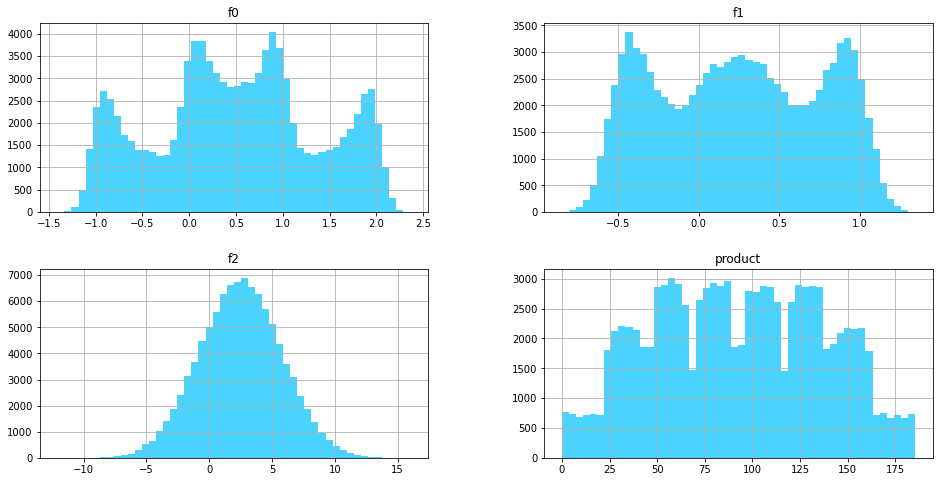

In [16]:
# Визуализируем распределения переменных при помощи гистограмм для региона geo_data_0:
data_0.hist(figsize=(16, 8), bins=50, alpha=0.7, color='deepskyblue')
plt.show()

In [17]:
# 2. Выведем числовое описание данных в датасете data_1, применив метод describe():
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


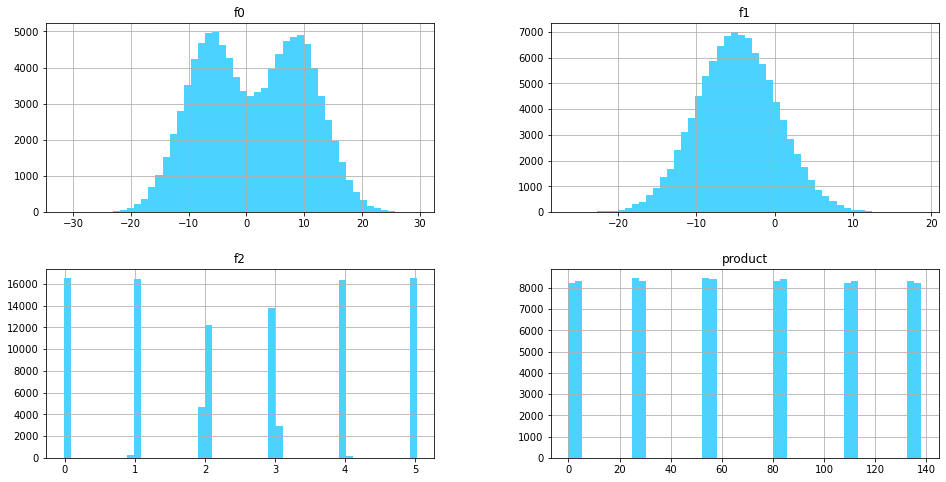

In [18]:
# Визуализируем распределения переменных при помощи гистограмм для региона geo_data_1:
data_1.hist(figsize=(16, 8), bins=50, alpha=0.7, color='deepskyblue')
plt.show()

In [19]:
# 3. Выведем числовое описание данных в датасете data_2, применив метод describe():
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


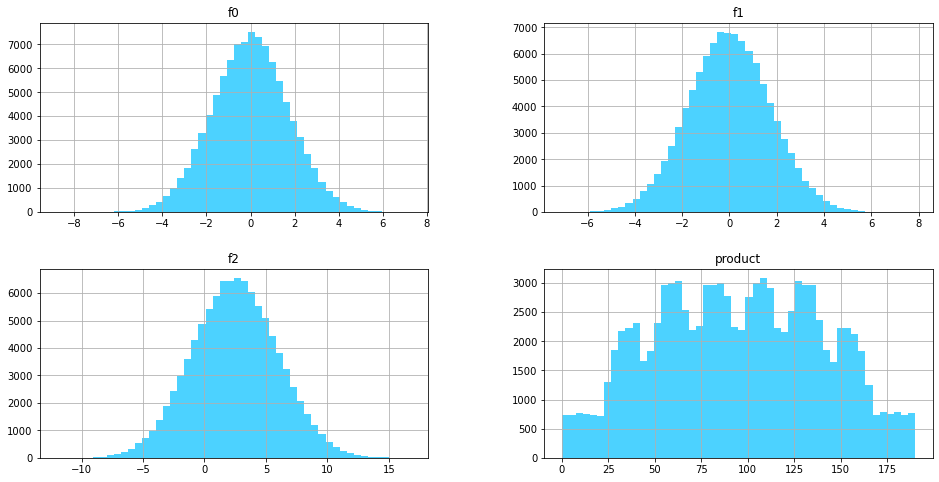

In [20]:
# Визуализируем распределения переменных при помощи гистограмм для региона geo_data_2:
data_2.hist(figsize=(16, 8), bins=50, alpha=0.7, color='deepskyblue')
plt.show()

Исходя из числового описания данных трёх датасетов видно, что средние и медианы не сильно отличаются между собой (кроме столбца *product* в датасете `data_1`), но присутствует сильный разброс значений - стандартное отклонение **std**: для данных из столбцов *f0*, *f1* и *f2* стандартное отклонение даже превышает среднее значение.

С другой строны, гистограммы показывают, что распределения переменных сильно отличаются друг от друга для разных регионов. Особенно сильно выделяются аномалии в данных столбцов *f2* и *product* в датасете `data_1`, которые будут мешать процессу обучения.

6. Проведём корреляционный анализ и посмотрим, как переменные взаимосвязаны между собой.

In [21]:
# Запишем в виде таблиц коэффициенты корреляции Пирсона для переменных трёх датасетов:

for region in range(len(data_all)):
    table_data = pd.DataFrame(
        [['f0', data_all[region]['f0'].corr(data_all[region]['f0']), data_all[region]['f1'].corr(data_all[region]['f0']),
          data_all[region]['f2'].corr(data_all[region]['f0']), data_all[region]['product'].corr(data_all[region]['f0'])],
        ['f1', data_all[region]['f0'].corr(data_all[region]['f1']), data_all[region]['f1'].corr(data_all[region]['f1']),
          data_all[region]['f2'].corr(data_all[region]['f1']), data_all[region]['product'].corr(data_all[region]['f1'])],
        ['f2', data_all[region]['f0'].corr(data_all[region]['f2']), data_all[region]['f1'].corr(data_all[region]['f2']),
          data_all[region]['f2'].corr(data_all[region]['f2']), data_all[region]['product'].corr(data_all[region]['f2'])],
        ['product', 
         data_all[region]['f0'].corr(data_all[region]['product']), data_all[region]['f1'].corr(data_all[region]['product']),
          data_all[region]['f2'].corr(data_all[region]['product']), 
         data_all[region]['product'].corr(data_all[region]['product'])]],
    columns=['', 'f0', 'f1', 'f2', 'product'])
    
    print(f'Для региона geo_data_{region}:')
    display(table_data)

Для региона geo_data_0:


,,f0,f1,f2,product
0,f0,1.000000,-0.440723,-0.003153,0.143536
1,f1,-0.440723,1.000000,0.001724,-0.192356
2,f2,-0.003153,0.001724,1.000000,0.483663
3,product,0.143536,-0.192356,0.483663,1.000000


Для региона geo_data_1:


,,f0,f1,f2,product
0,f0,1.000000,0.182287,-0.001777,-0.030491
1,f1,0.182287,1.000000,-0.002595,-0.010155
2,f2,-0.001777,-0.002595,1.000000,0.999397
3,product,-0.030491,-0.010155,0.999397,1.000000


Для региона geo_data_2:


,,f0,f1,f2,product
0,f0,1.000000,0.000528,-0.000448,-0.001987
1,f1,0.000528,1.000000,0.000779,-0.001012
2,f2,-0.000448,0.000779,1.000000,0.445871
3,product,-0.001987,-0.001012,0.445871,1.000000


Другой способ вывести коэффициенты корреляции Пирсона:

In [22]:
# Коэффициенты корреляции Пирсона для данных трёх датасетов:
for region in range(len(data_all)):
    print(f'Для региона geo_data_{region}:')
    display(data_all[region].corr())

Для региона geo_data_0:


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Для региона geo_data_1:


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Для региона geo_data_2:


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Сильная линейная зависимость присутствует между данными столбцов *f2* и *product* в датасете `data_1` (коэффициенты корреляции Пирсона = 0.999397), что подтверждает полученные ранее на гистограммах аномалии в данных столбцов *f2* и *product* в датасете `data_1`, которые будут мешать процессу обучения. Это ухудшает качество предсказаний моделью линейной регрессии. Для остальных датасетов эта зависимость выражена слабее.

Итак, данные подготовлены для исследования задачи.

## Обучение и проверка модели

**Задача 2. Обучим и проверим модель для каждого региона.**

Чтобы не выполнять задания для каждого региона отдельно, напишем цикл для списка *data_all* с данными по всем трём регионам. В этом цикле будут выполнены задания из нескольких пунктов **Задачи 2** сразу:
- **2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.**
- **2.2. Обучим модель и сделаем предсказания на валидационной выборке.**
- **2.3. Сохраним предсказания и правильные ответы на валидационной выборке.**
- **2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.**

In [23]:
state = np.random.RandomState(12345)

samples_target = [] # список правильных ответов по объёму сырья в скважине на валидационной выборке (тыс. баррелей)
samples_predictions = [] # список предсказаний по объёму сырья в скважине на валидационной выборке (тыс. баррелей)
samples_target_valid_sum = [] # список суммы правильных ответов по объёму сырья, соответствующих предсказаниям 
                                                                                                # (тыс. баррелей)
samples_mean_product = [] # список среднего запаса предсказанного сырья (тыс. баррелей)
samples_model_rmse = [] # список RMSE модели (тыс. баррелей)
for region in range(len(data_all)): # здесь len(data_all) = 3 (количество регионов)
    data = data_all[region]
    # Выделим из всех трёх датасетов по отдельности целевые признаки target (столбец 'product') и оставшиеся признаки 
                                                                                                           # features:
    features = data.drop('product', axis=1)
    target = data['product']
    
    # 2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25:
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=state)
    
    # 2.2. Обучим модель и сделаем предсказания на валидационной выборке:
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    # Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям:
    samples_target_valid_sum.append(target_valid.sum())
    
    # 2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
    # А также добавим индексацию к спискам для таргета и предсказаний с нумерацией по-порядку (от 0 до 24999). 
    # Одинаковая индексация понадобится нам для дальнейших задач:
      # сбросим индекс таргета и добавим в список правильных ответов на валидационной выборке (тыс. баррелей)
    samples_target.append(target_valid.reset_index(drop=True))
      # преобразуем исходный список с предсказаниями в проиндексированный (тыс. баррелей)
    samples_predictions.append(pd.Series(predictions))
    
    # 2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели:
    mean_product = predictions.mean()
    samples_mean_product.append(mean_product)
    model_rmse = mean_squared_error(target_valid, predictions)**0.5
    samples_model_rmse.append(model_rmse)
    
display('Сумма целевого значение объёма сырья, соответствующая предсказаниям, для трёх регионов: ', 
        samples_target_valid_sum)
display('Средний запас предсказанного сырья для трёх регионов: ', samples_mean_product)
display('RMSE модели для трёх регионов: ', samples_model_rmse)

'Сумма целевого значение объёма сырья, соответствующая предсказаниям, для трёх регионов: '

[2301964.918520732, 1719290.6062461617, 2368723.9679300603]

'Средний запас предсказанного сырья для трёх регионов: '

[92.59256778438035, 68.76995145799754, 95.087528122523]

'RMSE модели для трёх регионов: '

[37.5794217150813, 0.8897367737680649, 39.958042459521614]

**2.5. Проанализируем результаты.**

Только для датасета региона `geo_data_1` *RMSE* имеет маленькое значение (*RMSE* = 0.893099286775617). Для датасетов отсальных регионов `geo_data_0` и `geo_data_2` *RMSE* велика относительно среднего запаса предсказанного сырья, что говорит о сильном разбросе данных в таргетах этих датасетов.

## Подготовка к расчёту прибыли

**Задача 3. Подготовимся к расчёту прибыли.**

**3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.**

Напомним **условия задачи**:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Напомним **целевой признак:**
- *product* — объём запасов в скважине (тыс. баррелей)

**3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.**

In [24]:
# В условии задачи сказано, что при разведке региона из 100000 скважин необходимо выбрать n=200 лучших точек для разработки.
# При этом бюджет для каждого региона изначально заложен на 200 скважин.
# Рассчитаем достаточный объём сырья для одной скважины, при котором доходы равны расходам (тыс. баррелей):
product_balance = COST / (COUNT * REVENUE_PER_UNIT_PRODUCT)

# Здесь (expenses / COUNT) - это бюджет заложенный на одну скважину (тыс. рублей).

product_balance

111.11111111111111

In [25]:
# Средний запас предсказанного сырья для трёх регионов (тыс. баррелей):
display('Средний запас предсказанного сырья для трёх регионов: ', samples_mean_product)

'Средний запас предсказанного сырья для трёх регионов: '

[92.59256778438035, 68.76995145799754, 95.087528122523]

**3.3. Напишем выводы по этапу подготовки расчёта прибыли.**

Во всех регионах средний запас предсказанного сырья ниже объёма сырья для безубыточной разработки новой скважины. Т.е. концентрация продукта слишком низкая, чтобы выбирать точки случайно. Поэтому заданные 200 лучших скважин необходимо выбрать с помощью машинного обучения.

## Расчёт прибыли и рисков 

**Задача 4. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.**

Напишем функцию `profit()`, которая подсчитывает и возвращает прибыль `revenue - COST`. Она получает на вход:
- список правильных ответов `target` - объём запасов в скважине *product* (тыс. баррелей);
- список предсказаний `predictions` - с помощью сортировки модель выводит максимальные значения предсказаний (тыс. баррелей);
- количество лучших скважин, которые нужно выбрать для разработки в каждом регионе с помощью машинного обучения, `COUNT`.

Функция должна выбрать 200 скважин с наибольшим объёмом запасов и на основе ответов подсчитать прибыль `revenue - COST`.

В этой функции будут выполнены задания из нескольких пунктов **Задачи 4** сразу:
- **4.1. Выберем скважины с максимальными значениями предсказаний.**
- **4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.**
- **4.3. Рассчитаем прибыль для полученного объёма сырья.**

In [26]:
def profit(target, predictions, COUNT):
    # 4.1. Выберем скважины с максимальными значениями предсказаний (COUNT=200):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected_points = target[predictions_sorted.index][:COUNT]
    
    # 4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям (для COUNT=200):
    product = selected_points.sum()
    
    # Рассчитаем выручку для полученного объёма сырья:
    revenue = product * REVENUE_PER_UNIT_PRODUCT
    # 4.3. Рассчитаем прибыль для полученного объёма сырья:
    return revenue - COST

**Задача 5. Посчитаем риски и прибыль для каждого региона.**

В этом цикле будут выполнены задания из нескольких пунктов **Задачи 5** сразу:
- **5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.**
- **5.2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.**

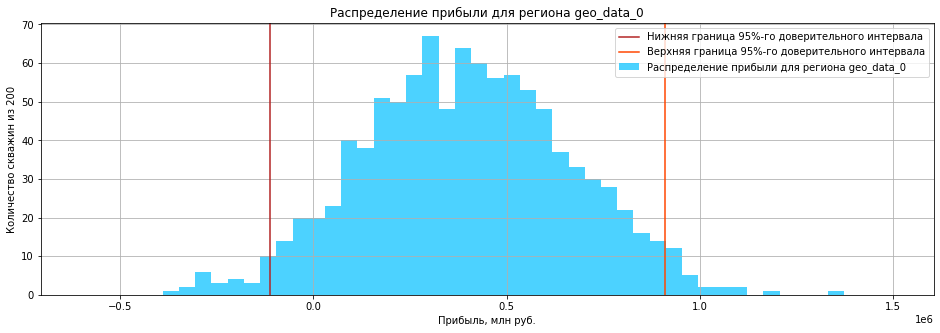

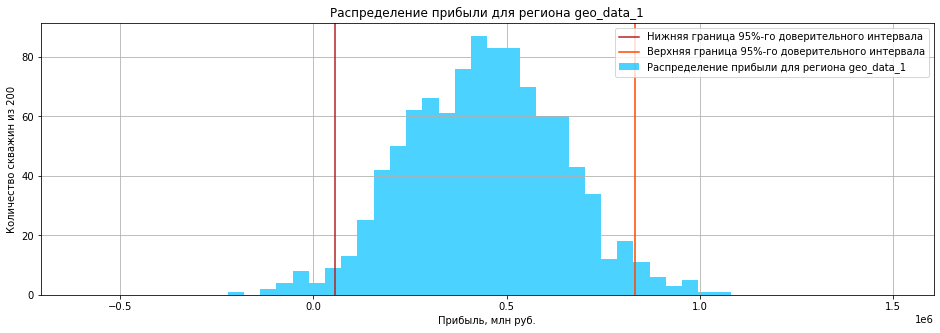

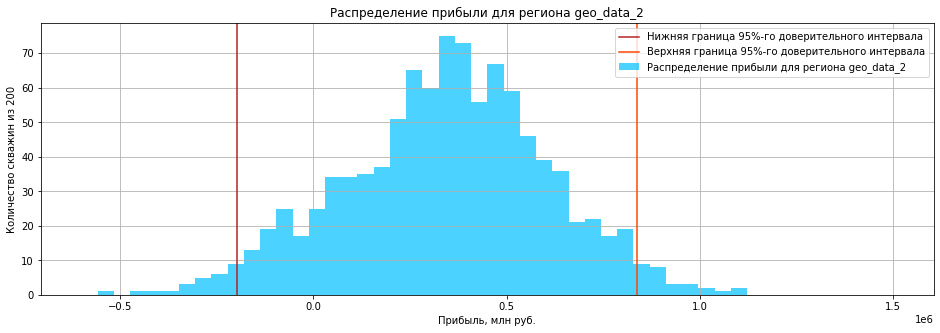

Средняя прибыль, 95%-й доверительный интервал и риск убытков от 200 лучших скважин:


,Регион,Средняя прибыль от 200 лучших скважин (млн рублей),95%-й доверительный интервал от 200 лучших скважин (млн рублей),Риск убытков от 200 лучших скважин (%)
0,geo_data_0:,396,"(-111, 910)",6.9
1,geo_data_1:,443,"(56, 831)",1.6
2,geo_data_2:,345,"(-198, 836)",10.8


In [27]:
# Создадим пустой датафрейм table, чтобы потом добавлять в него в цикле по одной строке row:
table = pd.DataFrame(
    columns=['Регион',
             'Средняя прибыль от 200 лучших скважин (млн рублей)', 
             '95%-й доверительный интервал от 200 лучших скважин (млн рублей)', 
             'Риск убытков от 200 лучших скважин (%)']
)


# Напишем цикл для подсчёта средней прибыли, 95%-го доверительного интервала и риска убытков для каждого региона.

state = np.random.RandomState(12345)

for region in range(len(data_all)):
    target = samples_target[region] # выбираем элемент region по порядку из списка правильных ответов 
                                                                                            # на валидационной выборке
    predictions = samples_predictions[region] # выбираем элемент region из списка предсказаний на валидационной выборке
    
    # 5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли:
    BOOTSTRAP_SIZE = 1000 # количество выборок
    profit_values = [] # список с прибылью от 200 лучших скважин для разработки в каждом регионе (тыс. рублей)
    for i in range(BOOTSTRAP_SIZE):
        
        # вариант кода №1:
        target_sample = target.sample(SAMPLE_SIZE, replace=True, random_state=state) # выбираем 500 скважин из таргета
        predictions_sample = predictions[target_sample.index] # выбираем соответствующие этим 500 скважинам предсказания
        target_sample = target_sample.reset_index(drop = True) # сбросим индекс
        predictions_sample = predictions_sample.reset_index(drop = True) # сбросим индекс
        profit_values.append(profit(target_sample, predictions_sample, COUNT)) # список с прибылью от 200 лучших скважин
                
#         # либо вариант кода №2 (без отбора по индексам - метод .index):
#         predictions_sample = predictions.sample(SAMPLE_SIZE, replace=True,
#                                                 random_state=state) # выбираем 500 скважин из предсказаний
#         profit_values.append(profit(target, predictions_sample, COUNT)) # список с прибылью от 200 лучших скважин

        
    profit_values = pd.Series(profit_values) # преобразуем список с прибылью от 200 лучших скважин в объект Series 
                                                                                                        # (тыс. рублей)
    # profit_values = round(profit_values/1000) # округляем прибыль в объекте Series до млн руб.
    
    # 5.2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль:
      # средняя прибыль от 200 лучших скважин для каждого региона (млн рублей)
    mean_profit = round(profit_values.mean()/1000)

      # 95%-й доверительный интервал от 200 лучших скважин для каждого региона (млн рублей)
    # confidence_interval = (profit_values.quantile(0.025), profit_values.quantile(0.975)) 
    confidence_interval = (f'{profit_values.quantile(0.025)/1000:.0f}', f'{profit_values.quantile(0.975)/1000:.0f}') 

      # риск убытков от 200 лучших скважин для каждого региона (%)
    negative_profit_chance = (profit_values < 0).mean()*100

 
    # выведем все искомые параметры в виде датафрейма table:
    row = [f'geo_data_{region}:', mean_profit, confidence_interval, negative_profit_chance]
    table.loc[len(table)] = row
   
    
    # построим гистограммы распределения прибыли для трёх регионов:
    profit_values.hist(figsize=(16, 5), bins=50, alpha=0.7, range = (-0.6*10**6, 1.5*10**6), color='deepskyblue')
    plt.grid(True)
    plt.axvline(profit_values.quantile(0.025), color='firebrick')
    plt.axvline(profit_values.quantile(0.975), color='orangered')
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
                'Верхняя граница 95%-го доверительного интервала', f'Распределение прибыли для региона geo_data_{region}'])
    plt.xlabel('Прибыль, млн руб.')
    plt.ylabel('Количество скважин из 200')
    plt.title(f'Распределение прибыли для региона geo_data_{region}')
    plt.show()

print('\033[1m' + 'Средняя прибыль, 95%-й доверительный интервал и риск убытков от 200 лучших скважин:' + '\033[0m')
display(table)

**5.3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.**

Риск убытков от 200 лучших скважин для каждого из трёх регионов составляет 6.9%, 1.6% и 10.8%, соответственно. Таким образом, только в регионе `geo_data_1` вероятность убытков меньше 2.5%. А значит, для разработки скважин можно предложить регион `geo_data_1`. Средняя прибыль в этом регионе состаляет 443 млн рублей, а также 95%-й доверительный интервал не содержит отрицательных значений.

## Общий вывод

Провести исследование с целью построения модели машинного обучения, которая поможет определить регион, где добыча нефти принесёт наибольшую прибыль.

Входные данные – пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.

Результаты исследования позволят увеличить прибыль добывающей компании «ГлавРосГосНефть».

Перед проведением исследования была сформулирована гипотеза:
- Гипотеза: среди трёх регионов есть те, в которых вероятность убытков меньше 2.5%.

В результате удалось получить следующие результаты.

<b>Гипотеза подтверждена:</b>

- 6.9% - вероятность убытков в  регионе `geo_data_0`;
- 1.6% - вероятность убытков в  регионе `geo_data_1`;
- 10.8% - вероятность убытков в  регионе `geo_data_2`.

Рекомендация: только в одном регионе `geo_data_1` вероятность убытков меньше 2.5%.

<b>Общие рекомендации:</b>

Специалистам, которые занимаются исследованием с целью увеличения прибыли добывающей компании «ГлавРосГосНефть», можно предложить регион `geo_data_1` для разработки скважин. Этот регион также позволяет получить наибольшую среднюю прибыль - 443 млн рублей.